Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [2]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=606173cf9e5e4d9fbee9e316f426ae2f22d8e72811f96c6f95d65fd3bf7a1a90
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [3]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [4]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['O', 'I-test', 'I-problem', 'I-treatment', 'B-test', 'B-problem', 'B-treatment']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['O', 'I-test', 'I-problem', 'I-treatment', 'B-test', 'B-problem', 'B-treatment']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['O', 'I-test', 'I-problem', 'I-treatment', 'B-test', 'B-problem', 'B-treatment']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [5]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

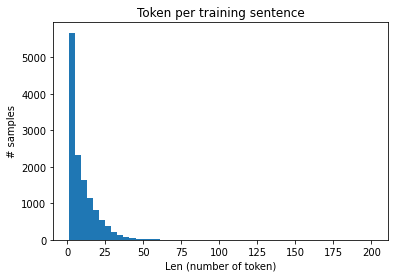

In [6]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

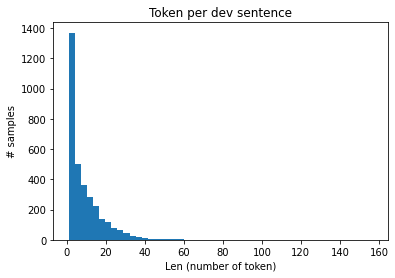

In [7]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

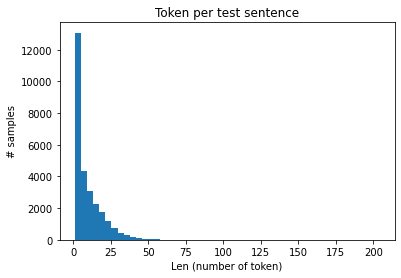

In [8]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [9]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

18004
1986-03-06
6
B-test


In [10]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [11]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9617)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 500
Points in y_train before removal: 500


In [12]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [13]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[16761, 8672, 15787, 8672, 27952, 8672, 3178, 8672, 19560, 17788, 8574]
[6, 0, 6, 0, 6, 0, 6, 0, 0, 6, 0]
[22054, 1227, 24757, 21520, 23279, 11829, 18845, 17224, 5435, 25310, 8313, 5775, 13529, 8574]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8415, 25255, 21363]
[0, 0, 0]
18004
6
I-problem
EBV
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 12.4 MB/s 
     |████████████████████████████████| 101 kB 11.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.9 MB/s 
     |████████████████████████████████| 596 kB 61.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f6a858ad8df309873970ca6f50be03b157ecaaab9c21097dea6a99147310bcc1
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[16761, 8672, 15787, 8672, 27952, 8672, 3178, 8672, 19560, 17788, 8574]
[6, 0, 6, 0, 6, 0, 6, 0, 0, 6, 0]
[22054, 1227, 24757, 21520, 23279, 11829, 18845, 17224, 5435, 25310, 8313, 5775, 13529, 8574]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8415, 25255, 21363]
[0, 0, 0]
18004
6
I-problem
EBV
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [22]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0678205490112305
Training loss epoch: 0.6243727914988995
Training accuracy epoch: 0.8120000000000003
Validating model...
Validation Loss: 0.3005111160523751
Validation Accuracy: 0.9031570961718021
Training epoch: 2
Training loss per 100 training steps: 0.1890353411436081
Training loss epoch: 0.19149742648005486
Training accuracy epoch: 0.9360000000000002
Validating model...
Validation Loss: 0.2815626909335454
Validation Accuracy: 0.9095714674758792
Training epoch: 3
Training loss per 100 training steps: 0.04583350569009781
Training loss epoch: 0.08225957849062979
Training accuracy epoch: 0.9700000000000001
Validating model...
Validation Loss: 0.29841157662517886
Validation Accuracy: 0.9264316837846249
Training epoch: 4
Training loss per 100 training steps: 0.00856395810842514
Training loss epoch: 0.01755817437078804
Training accuracy epoch: 0.9960000000000001
Validating model...
Validation Loss: 0.38686203911864
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2770996728989606
Validation Accuracy: 0.9117909115289069
Validation duration: 2.1031594 minutes
F1-score (test): 69.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.26      0.41      1170
        test       0.72      0.83      0.77      2464
   treatment       0.93      0.56      0.70      1244

   micro avg       0.78      0.62      0.69      4878
   macro avg       0.86      0.55      0.63      4878
weighted avg       0.82      0.62      0.67      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9477251768112183
Training loss epoch: 0.6582886859774589
Training accuracy epoch: 0.784
Validating model...
Validation Loss: 0.304389540179103
Validation Accuracy: 0.8985663709928415
Training epoch: 2
Training loss per 100 training steps: 0.16610805690288544
Training loss epoch: 0.1869129056110978
Training accuracy epoch: 0.9360000000000002
Validating model...
Validation Loss: 0.24883033715042413
Validation Accuracy: 0.9166374883286648
Training epoch: 3
Training loss per 100 training steps: 0.10890252143144608
Training loss epoch: 0.05471273842267692
Training accuracy epoch: 0.984
Validating model...
Validation Loss: 0.34410067026813823
Validation Accuracy: 0.9059193121693121
Training epoch: 4
Training loss per 100 training steps: 0.055287450551986694
Training loss epoch: 0.07490357575006783
Training accuracy epoch: 0.9760000000000002
Validating model...
Validation Loss: 0.271849804649166
Validation Accuracy: 0.9329044117647058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2539795786142349
Validation Accuracy: 0.9137078675474255
Validation duration: 2.090706083333333 minutes
F1-score (test): 74.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.57      0.71      0.63      1170
        test       0.70      0.88      0.78      2464
   treatment       0.86      0.70      0.78      1244

   micro avg       0.69      0.80      0.74      4878
   macro avg       0.71      0.77      0.73      4878
weighted avg       0.71      0.80      0.74      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.086927890777588
Training loss epoch: 0.7151934549212455
Training accuracy epoch: 0.792
Validating model...
Validation Loss: 0.36437025841544657
Validation Accuracy: 0.8798533302209773
Training epoch: 2
Training loss per 100 training steps: 0.13940051198005676
Training loss epoch: 0.2342537662014365
Training accuracy epoch: 0.9299999999999999
Validating model...
Validation Loss: 0.26042284685022693
Validation Accuracy: 0.9163457049486461
Training epoch: 3
Training loss per 100 training steps: 0.05299123376607895
Training loss epoch: 0.08376197153702378
Training accuracy epoch: 0.9720000000000001
Validating model...
Validation Loss: 0.4152432009577751
Validation Accuracy: 0.9007158418923125
Training epoch: 4
Training loss per 100 training steps: 0.008673036471009254
Training loss epoch: 0.03850281101185828
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.24892672472724728
Validation Accuracy: 0.9331864690320572

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24855912713058018
Validation Accuracy: 0.9334243733062331
Validation duration: 2.088686100000001 minutes
F1-score (test): 77.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.51      0.64      1170
        test       0.87      0.79      0.83      2464
   treatment       0.84      0.70      0.76      1244

   micro avg       0.85      0.70      0.77      4878
   macro avg       0.85      0.67      0.74      4878
weighted avg       0.85      0.70      0.77      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.013950824737549
Training loss epoch: 0.6908354252576828
Training accuracy epoch: 0.7860000000000003
Validating model...
Validation Loss: 0.3255620394267288
Validation Accuracy: 0.8991742530345471
Training epoch: 2
Training loss per 100 training steps: 0.2759939134120941
Training loss epoch: 0.20872841970995068
Training accuracy epoch: 0.9380000000000001
Validating model...
Validation Loss: 0.25731587892069535
Validation Accuracy: 0.9255174291938997
Training epoch: 3
Training loss per 100 training steps: 0.060888778418302536
Training loss epoch: 0.061379936244338754
Training accuracy epoch: 0.982
Validating model...
Validation Loss: 0.25979264241223243
Validation Accuracy: 0.9301032913165266
Training epoch: 4
Training loss per 100 training steps: 0.01691414788365364
Training loss epoch: 0.023251615278422833
Training accuracy epoch: 0.9940000000000001
Validating model...
Validation Loss: 0.2464507425240442
Validation Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24592259157496435
Validation Accuracy: 0.9383274757226738
Validation duration: 2.0835583166666654 minutes
F1-score (test): 78.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.58      0.68      1170
        test       0.86      0.81      0.84      2464
   treatment       0.85      0.71      0.77      1244

   micro avg       0.85      0.73      0.79      4878
   macro avg       0.85      0.70      0.76      4878
weighted avg       0.85      0.73      0.78      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1933577060699463
Training loss epoch: 0.7348812021315098
Training accuracy epoch: 0.7820000000000003
Validating model...
Validation Loss: 0.33009858867701364
Validation Accuracy: 0.8939513305322129
Training epoch: 2
Training loss per 100 training steps: 0.314127653837204
Training loss epoch: 0.262809269875288
Training accuracy epoch: 0.9080000000000001
Validating model...
Validation Loss: 0.24425075962847353
Validation Accuracy: 0.9203285480859009
Training epoch: 3
Training loss per 100 training steps: 0.19446252286434174
Training loss epoch: 0.08560821181163192
Training accuracy epoch: 0.974
Validating model...
Validation Loss: 0.2690700272134706
Validation Accuracy: 0.9261350373482726
Training epoch: 4
Training loss per 100 training steps: 0.024275748059153557
Training loss epoch: 0.02499422145774588
Training accuracy epoch: 0.9960000000000001
Validating model...
Validation Loss: 0.3572327437646249
Validation Accuracy: 0.92308

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24722962876505875
Validation Accuracy: 0.9179484600835592
Validation duration: 2.0867902166666683 minutes
F1-score (test): 73.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.42      0.54      1170
        test       0.77      0.81      0.79      2464
   treatment       0.79      0.71      0.75      1244

   micro avg       0.78      0.69      0.73      4878
   macro avg       0.78      0.64      0.69      4878
weighted avg       0.78      0.69      0.72      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.117093324661255
Training loss epoch: 0.7247739657759666
Training accuracy epoch: 0.788
Validating model...
Validation Loss: 0.3405499922878602
Validation Accuracy: 0.8906006847183318
Training epoch: 2
Training loss per 100 training steps: 0.2786043882369995
Training loss epoch: 0.2172308126464486
Training accuracy epoch: 0.9340000000000002
Validating model...
Validation Loss: 0.25701145856988195
Validation Accuracy: 0.9120613523187052
Training epoch: 3
Training loss per 100 training steps: 0.08322162926197052
Training loss epoch: 0.0546331278514117
Training accuracy epoch: 0.9860000000000001
Validating model...
Validation Loss: 0.2657566704221216
Validation Accuracy: 0.9276717631497042
Training epoch: 4
Training loss per 100 training steps: 0.02942928485572338
Training loss epoch: 0.008282718784175813
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.27580303837563475
Validation Accuracy: 0.9405539993775288
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2747814721186404
Validation Accuracy: 0.9048870469173442
Validation duration: 2.0786438000000014 minutes
F1-score (test): 70.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.63      0.65      1170
        test       0.61      0.92      0.73      2464
   treatment       0.94      0.53      0.68      1244

   micro avg       0.66      0.75      0.70      4878
   macro avg       0.74      0.69      0.69      4878
weighted avg       0.71      0.75      0.70      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8121169805526733
Training loss epoch: 0.6394073888659477
Training accuracy epoch: 0.804
Validating model...
Validation Loss: 0.347508535081265
Validation Accuracy: 0.8912182928727046
Training epoch: 2
Training loss per 100 training steps: 0.2658998966217041
Training loss epoch: 0.2076034938916564
Training accuracy epoch: 0.9359999999999999
Validating model...
Validation Loss: 0.255180950550472
Validation Accuracy: 0.9246080376595082
Training epoch: 3
Training loss per 100 training steps: 0.09201568365097046
Training loss epoch: 0.06562996227294207
Training accuracy epoch: 0.9840000000000002
Validating model...
Validation Loss: 0.2680550353492008
Validation Accuracy: 0.9285957438530968
Training epoch: 4
Training loss per 100 training steps: 0.00883070845156908
Training loss epoch: 0.030007939285133033
Training accuracy epoch: 0.9940000000000001
Validating model...
Validation Loss: 0.27232224552654755
Validation Accuracy: 0.932875

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2531572883620996
Validation Accuracy: 0.9208622685185185
Validation duration: 2.125326483333333 minutes
F1-score (test): 71.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.63      0.61      0.62      1170
        test       0.92      0.67      0.77      2464
   treatment       0.84      0.61      0.70      1244

   micro avg       0.81      0.64      0.71      4878
   macro avg       0.79      0.63      0.70      4878
weighted avg       0.83      0.64      0.72      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.719334602355957
Training loss epoch: 0.6602197520434856
Training accuracy epoch: 0.8019999999999999
Validating model...
Validation Loss: 0.2969536591394275
Validation Accuracy: 0.9154265873015872
Training epoch: 2
Training loss per 100 training steps: 0.11295189708471298
Training loss epoch: 0.22257465831935405
Training accuracy epoch: 0.9339999999999999
Validating model...
Validation Loss: 0.2383456528186798
Validation Accuracy: 0.9325785869903517
Training epoch: 3
Training loss per 100 training steps: 0.023740878328680992
Training loss epoch: 0.06619751006364823
Training accuracy epoch: 0.9880000000000001
Validating model...
Validation Loss: 0.2366857846797097
Validation Accuracy: 0.9334977046374106
Training epoch: 4
Training loss per 100 training steps: 0.01693337969481945
Training loss epoch: 0.011794123495928944
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.2624082855295901
Validation Accuracy: 0.93564

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24388288506048006
Validation Accuracy: 0.9320093721770552
Validation duration: 2.182697133333333 minutes
F1-score (test): 76.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.58      0.67      1170
        test       0.92      0.73      0.81      2464
   treatment       0.88      0.67      0.76      1244

   micro avg       0.88      0.68      0.77      4878
   macro avg       0.87      0.66      0.75      4878
weighted avg       0.88      0.68      0.77      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.7298848628997803
Training loss epoch: 0.7285051718354225
Training accuracy epoch: 0.782
Validating model...
Validation Loss: 0.2903228472260868
Validation Accuracy: 0.9086815281668222
Training epoch: 2
Training loss per 100 training steps: 0.19897985458374023
Training loss epoch: 0.19501542989164591
Training accuracy epoch: 0.9340000000000002
Validating model...
Validation Loss: 0.21948213276325487
Validation Accuracy: 0.9380932928727046
Training epoch: 3
Training loss per 100 training steps: 0.09783466160297394
Training loss epoch: 0.0871973056346178
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.26829701870241585
Validation Accuracy: 0.9209267040149394
Training epoch: 4
Training loss per 100 training steps: 0.0240595955401659
Training loss epoch: 0.032630382559727875
Training accuracy epoch: 0.9940000000000001
Validating model...
Validation Loss: 0.2759656095329453
Validation Accuracy: 0.927

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2236021780581386
Validation Accuracy: 0.9286659468157181
Validation duration: 2.0953340666666613 minutes
F1-score (test): 76.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.62      0.66      1170
        test       0.85      0.77      0.81      2464
   treatment       0.83      0.72      0.77      1244

   micro avg       0.81      0.72      0.76      4878
   macro avg       0.80      0.70      0.75      4878
weighted avg       0.81      0.72      0.76      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 500
Points in y_train after augmentation: 500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.159419059753418
Training loss epoch: 0.7287348166108132
Training accuracy epoch: 0.78
Validating model...
Validation Loss: 0.3660747628001606
Validation Accuracy: 0.878968253968254
Training epoch: 2
Training loss per 100 training steps: 0.20328857004642487
Training loss epoch: 0.29554860182106496
Training accuracy epoch: 0.9120000000000003
Validating model...
Validation Loss: 0.3055991971609639
Validation Accuracy: 0.905894996887644
Training epoch: 3
Training loss per 100 training steps: 0.11909633874893188
Training loss epoch: 0.1030770292505622
Training accuracy epoch: 0.9680000000000002
Validating model...
Validation Loss: 0.3659248951019025
Validation Accuracy: 0.9148089791472145
Training epoch: 4
Training loss per 100 training steps: 0.01081455871462822
Training loss epoch: 0.03379005342721939
Training accuracy epoch: 0.992
Validating model...
Validation Loss: 0.43873890146941824
Validation Accuracy: 0.9160344693432929
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2768264781355996
Validation Accuracy: 0.9225736788617886
Validation duration: 2.1626318000000007 minutes
F1-score (test): 75.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.59      0.66      1170
        test       0.75      0.86      0.80      2464
   treatment       0.81      0.66      0.73      1244

   micro avg       0.77      0.74      0.75      4878
   macro avg       0.77      0.70      0.73      4878
weighted avg       0.77      0.74      0.75      4878



In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8978325128555298
Training loss epoch: 0.6102941362630754
Training accuracy epoch: 0.8092165898617509
Validating model...
Validation Loss: 0.40050454817566217
Validation Accuracy: 0.8562529178338002
Training epoch: 2
Training loss per 100 training steps: 0.4751279950141907
Training loss epoch: 0.17286302191427066
Training accuracy epoch: 0.9477726574500768
Validating model...
Validation Loss: 0.35195943274918723
Validation Accuracy: 0.9025346249610956
Training epoch: 3
Training loss per 100 training steps: 0.03474674001336098
Training loss epoch: 0.051329324288027625
Training accuracy epoch: 0.9831029185867896
Validating model...
Validation Loss: 0.2915363957484563
Validation Accuracy: 0.927360527544351
Training epoch: 4
Training loss per 100 training steps: 0.02403571642935276
Training loss epoch: 0.05949728167615831
Training accuracy epoch: 0.9874039938556068
Validating model...
Validation Loss: 0.2828824742167604
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28353113895799553
Validation Accuracy: 0.9163411458333334
Validation duration: 3.2729823999999996 minutes
F1-score (test): 73.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.59      0.68      1170
        test       0.65      0.87      0.75      2464
   treatment       0.81      0.69      0.75      1244

   micro avg       0.71      0.76      0.73      4878
   macro avg       0.76      0.72      0.73      4878
weighted avg       0.73      0.76      0.73      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7807624340057373
Training loss epoch: 0.6354239412716457
Training accuracy epoch: 0.8076804915514593
Validating model...
Validation Loss: 0.3211781557868509
Validation Accuracy: 0.8890445066915655
Training epoch: 2
Training loss per 100 training steps: 0.27006468176841736
Training loss epoch: 0.15866809551204955
Training accuracy epoch: 0.953917050691244
Validating model...
Validation Loss: 0.30689825906473045
Validation Accuracy: 0.9187626439464674
Training epoch: 3
Training loss per 100 training steps: 0.00819536205381155
Training loss epoch: 0.055825747549533844
Training accuracy epoch: 0.9846390168970816
Validating model...
Validation Loss: 0.33296150473110814
Validation Accuracy: 0.9178581154684096
Training epoch: 4
Training loss per 100 training steps: 0.017696380615234375
Training loss epoch: 0.018038592717078115
Training accuracy epoch: 0.9969278033794163
Validating model...
Validation Loss: 0.27409528791174
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2604589275153423
Validation Accuracy: 0.9246308999548328
Validation duration: 3.264359299999997 minutes
F1-score (test): 76.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.56      0.66      1170
        test       0.74      0.86      0.80      2464
   treatment       0.84      0.71      0.77      1244

   micro avg       0.77      0.75      0.76      4878
   macro avg       0.80      0.71      0.74      4878
weighted avg       0.78      0.75      0.76      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9598644971847534
Training loss epoch: 0.6642342635563442
Training accuracy epoch: 0.798463901689708
Validating model...
Validation Loss: 0.33460547701985227
Validation Accuracy: 0.8881497043261749
Training epoch: 2
Training loss per 100 training steps: 0.4884701371192932
Training loss epoch: 0.23603762426812733
Training accuracy epoch: 0.9216589861751151
Validating model...
Validation Loss: 0.2417058248584177
Validation Accuracy: 0.9236840569561158
Training epoch: 3
Training loss per 100 training steps: 0.027150560170412064
Training loss epoch: 0.0702797202615156
Training accuracy epoch: 0.9877112135176653
Validating model...
Validation Loss: 0.3014637997337416
Validation Accuracy: 0.922478018985372
Training epoch: 4
Training loss per 100 training steps: 0.019410377368330956
Training loss epoch: 0.024163348068084036
Training accuracy epoch: 0.9938556067588326
Validating model...
Validation Loss: 0.35907544619312476
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.25260073177654435
Validation Accuracy: 0.9182739809168926
Validation duration: 3.26288045 minutes
F1-score (test): 71.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.45      0.55      1170
        test       0.85      0.75      0.80      2464
   treatment       0.88      0.57      0.69      1244

   micro avg       0.83      0.63      0.72      4878
   macro avg       0.81      0.59      0.68      4878
weighted avg       0.82      0.63      0.71      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.084120988845825
Training loss epoch: 0.6613640728450957
Training accuracy epoch: 0.7858678955453148
Validating model...
Validation Loss: 0.3160482554459104
Validation Accuracy: 0.902870175848117
Training epoch: 2
Training loss per 100 training steps: 0.2894051969051361
Training loss epoch: 0.2575542799064091
Training accuracy epoch: 0.9152073732718894
Validating model...
Validation Loss: 0.2701664683865566
Validation Accuracy: 0.9141962340491753
Training epoch: 3
Training loss per 100 training steps: 0.1751089245080948
Training loss epoch: 0.10737338945979163
Training accuracy epoch: 0.9597542242703535
Validating model...
Validation Loss: 0.23910677907805816
Validation Accuracy: 0.9319512527233115
Training epoch: 4
Training loss per 100 training steps: 0.05144459754228592
Training loss epoch: 0.03428467187941784
Training accuracy epoch: 0.9923195084485408
Validating model...
Validation Loss: 0.3516026669565369
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24184837717028265
Validation Accuracy: 0.9302573820009032
Validation duration: 3.260663466666669 minutes
F1-score (test): 76.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.55      0.65      1170
        test       0.84      0.81      0.83      2464
   treatment       0.89      0.61      0.72      1244

   micro avg       0.84      0.69      0.76      4878
   macro avg       0.84      0.65      0.73      4878
weighted avg       0.84      0.69      0.76      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.574981689453125
Training loss epoch: 0.6634542810774985
Training accuracy epoch: 0.7941628264208909
Validating model...
Validation Loss: 0.29127552783956717
Validation Accuracy: 0.9163408418923125
Training epoch: 2
Training loss per 100 training steps: 0.1789894700050354
Training loss epoch: 0.16310284357695354
Training accuracy epoch: 0.9539170506912443
Validating model...
Validation Loss: 0.31571877010020555
Validation Accuracy: 0.9095860566448801
Training epoch: 3
Training loss per 100 training steps: 0.02673562988638878
Training loss epoch: 0.05505962545673052
Training accuracy epoch: 0.9815668202764977
Validating model...
Validation Loss: 0.2865598625412174
Validation Accuracy: 0.9252159197012139
Training epoch: 4
Training loss per 100 training steps: 0.006504191551357508
Training loss epoch: 0.0120458744543915
Training accuracy epoch: 0.9969278033794163
Validating model...
Validation Loss: 0.26044891175686147
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26899785144444277
Validation Accuracy: 0.9336731453252033
Validation duration: 3.258165383333335 minutes
F1-score (test): 78.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.73      0.70      1170
        test       0.85      0.81      0.83      2464
   treatment       0.90      0.66      0.76      1244

   micro avg       0.81      0.75      0.78      4878
   macro avg       0.81      0.73      0.76      4878
weighted avg       0.82      0.75      0.78      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0758719444274902
Training loss epoch: 0.6282554197879064
Training accuracy epoch: 0.8156682027649768
Validating model...
Validation Loss: 0.3224068197841738
Validation Accuracy: 0.8853826252723311
Training epoch: 2
Training loss per 100 training steps: 0.21274025738239288
Training loss epoch: 0.18428588773877846
Training accuracy epoch: 0.9370199692780338
Validating model...
Validation Loss: 0.2349235968773856
Validation Accuracy: 0.9298260971055088
Training epoch: 3
Training loss per 100 training steps: 0.02348855324089527
Training loss epoch: 0.07441887503401154
Training accuracy epoch: 0.9738863287250383
Validating model...
Validation Loss: 0.23086216315334918
Validation Accuracy: 0.9322576252723311
Training epoch: 4
Training loss per 100 training steps: 0.01635603979229927
Training loss epoch: 0.03054821648679319
Training accuracy epoch: 0.9938556067588328
Validating model...
Validation Loss: 0.27354921269066196
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.22677697841491964
Validation Accuracy: 0.9309287135840109
Validation duration: 3.2608484000000013 minutes
F1-score (test): 76.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.68      0.70      1170
        test       0.90      0.71      0.79      2464
   treatment       0.85      0.72      0.78      1244

   micro avg       0.84      0.70      0.77      4878
   macro avg       0.82      0.70      0.76      4878
weighted avg       0.84      0.70      0.77      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8039313554763794
Training loss epoch: 0.662788321574529
Training accuracy epoch: 0.7938556067588325
Validating model...
Validation Loss: 0.324098222395953
Validation Accuracy: 0.9000885076252723
Training epoch: 2
Training loss per 100 training steps: 0.36454883217811584
Training loss epoch: 0.20281033067121393
Training accuracy epoch: 0.9308755760368663
Validating model...
Validation Loss: 0.24683520387785107
Validation Accuracy: 0.9267526455026455
Training epoch: 3
Training loss per 100 training steps: 0.08454899489879608
Training loss epoch: 0.06279877226777553
Training accuracy epoch: 0.9877112135176651
Validating model...
Validation Loss: 0.2613626287556162
Validation Accuracy: 0.9328898225957049
Training epoch: 4
Training loss per 100 training steps: 0.02232879027724266
Training loss epoch: 0.02193892382395764
Training accuracy epoch: 0.9938556067588326
Validating model...
Validation Loss: 0.26560845510924563
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2383591267970149
Validation Accuracy: 0.926857497741644
Validation duration: 3.2661512833333366 minutes
F1-score (test): 75.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.53      0.62      1170
        test       0.84      0.81      0.83      2464
   treatment       0.76      0.69      0.73      1244

   micro avg       0.80      0.71      0.76      4878
   macro avg       0.78      0.68      0.72      4878
weighted avg       0.80      0.71      0.75      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0163626670837402
Training loss epoch: 0.6750831987176623
Training accuracy epoch: 0.7800307219662057
Validating model...
Validation Loss: 0.32257311396739063
Validation Accuracy: 0.8875126439464674
Training epoch: 2
Training loss per 100 training steps: 0.14008121192455292
Training loss epoch: 0.20308631835948854
Training accuracy epoch: 0.9305683563748081
Validating model...
Validation Loss: 0.21007768093955284
Validation Accuracy: 0.9304485683162153
Training epoch: 3
Training loss per 100 training steps: 0.04047994315624237
Training loss epoch: 0.07677425772306465
Training accuracy epoch: 0.9769585253456222
Validating model...
Validation Loss: 0.24439185638638103
Validation Accuracy: 0.924899821039527
Training epoch: 4
Training loss per 100 training steps: 0.02399926632642746
Training loss epoch: 0.035383760618666805
Training accuracy epoch: 0.9938556067588328
Validating model...
Validation Loss: 0.2517235978853469
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2292951337510237
Validation Accuracy: 0.9242330411585366
Validation duration: 3.271053299999994 minutes
F1-score (test): 74.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.58      0.63      1170
        test       0.78      0.85      0.81      2464
   treatment       0.93      0.57      0.71      1244

   micro avg       0.78      0.72      0.75      4878
   macro avg       0.80      0.67      0.72      4878
weighted avg       0.79      0.72      0.74      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.107640266418457
Training loss epoch: 0.6882081996826899
Training accuracy epoch: 0.7892473118279568
Validating model...
Validation Loss: 0.3391332968192942
Validation Accuracy: 0.8896961562402739
Training epoch: 2
Training loss per 100 training steps: 0.3405395746231079
Training loss epoch: 0.2304148549834887
Training accuracy epoch: 0.9278033794162823
Validating model...
Validation Loss: 0.24712715064193688
Validation Accuracy: 0.9160198801742919
Training epoch: 3
Training loss per 100 training steps: 0.16986681520938873
Training loss epoch: 0.06879680931922935
Training accuracy epoch: 0.9861751152073734
Validating model...
Validation Loss: 0.24212525814187294
Validation Accuracy: 0.9279878618113911
Training epoch: 4
Training loss per 100 training steps: 0.03901809826493263
Training loss epoch: 0.01976715841530157
Training accuracy epoch: 0.9923195084485408
Validating model...
Validation Loss: 0.2815408952095929
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2549543883651495
Validation Accuracy: 0.9220311441395664
Validation duration: 3.265147433333338 minutes
F1-score (test): 73.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.44      0.55      1170
        test       0.78      0.84      0.81      2464
   treatment       0.94      0.58      0.72      1244

   micro avg       0.80      0.68      0.74      4878
   macro avg       0.81      0.62      0.69      4878
weighted avg       0.81      0.68      0.72      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 625
Points in y_train after augmentation: 625
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9166382551193237
Training loss epoch: 0.6735365901674543
Training accuracy epoch: 0.7969278033794163
Validating model...
Validation Loss: 0.345195705984153
Validation Accuracy: 0.8930419389978212
Training epoch: 2
Training loss per 100 training steps: 0.1833219826221466
Training loss epoch: 0.26703133558233577
Training accuracy epoch: 0.9124423963133637
Validating model...
Validation Loss: 0.3137526447866477
Validation Accuracy: 0.9068189775910364
Training epoch: 3
Training loss per 100 training steps: 0.14899635314941406
Training loss epoch: 0.11541123209255082
Training accuracy epoch: 0.967741935483871
Validating model...
Validation Loss: 0.23112101166271695
Validation Accuracy: 0.9347134687208216
Training epoch: 4
Training loss per 100 training steps: 0.019461069256067276
Training loss epoch: 0.029023294093176014
Training accuracy epoch: 0.9892473118279571
Validating model...
Validation Loss: 0.26084064078681607
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24523973435215238
Validation Accuracy: 0.9297713061766034
Validation duration: 3.2638944333333257 minutes
F1-score (test): 76.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.60      0.67      1170
        test       0.83      0.81      0.82      2464
   treatment       0.91      0.59      0.71      1244

   micro avg       0.83      0.70      0.76      4878
   macro avg       0.83      0.67      0.73      4878
weighted avg       0.83      0.70      0.76      4878



In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3526647090911865
Training loss epoch: 0.7029276460409164
Training accuracy epoch: 0.787687969924812
Validating model...
Validation Loss: 0.3083313852548599
Validation Accuracy: 0.9022379785247432
Training epoch: 2
Training loss per 100 training steps: 0.2525472044944763
Training loss epoch: 0.1657810902222991
Training accuracy epoch: 0.949906015037594
Validating model...
Validation Loss: 0.2837340056019671
Validation Accuracy: 0.9144831543728603
Training epoch: 3
Training loss per 100 training steps: 0.05396468937397003
Training loss epoch: 0.0721481200074777
Training accuracy epoch: 0.9789473684210526
Validating model...
Validation Loss: 0.2517750894322115
Validation Accuracy: 0.927360527544351
Training epoch: 4
Training loss per 100 training steps: 0.06681742519140244
Training loss epoch: 0.020894861058332027
Training accuracy epoch: 0.9973684210526315
Validating model...
Validation Loss: 0.2939082197844982
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28545920169670824
Validation Accuracy: 0.9170557037601625
Validation duration: 3.2876269500000035 minutes
F1-score (test): 72.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.72      0.59      1170
        test       0.83      0.79      0.81      2464
   treatment       0.92      0.58      0.71      1244

   micro avg       0.73      0.72      0.73      4878
   macro avg       0.75      0.70      0.70      4878
weighted avg       0.77      0.72      0.73      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8614513874053955
Training loss epoch: 0.6691746175289154
Training accuracy epoch: 0.7971804511278195
Validating model...
Validation Loss: 0.3801519423723221
Validation Accuracy: 0.8761914488017428
Training epoch: 2
Training loss per 100 training steps: 0.25345590710639954
Training loss epoch: 0.19525595866143702
Training accuracy epoch: 0.9472744360902257
Validating model...
Validation Loss: 0.247566138558528
Validation Accuracy: 0.92890697945845
Training epoch: 3
Training loss per 100 training steps: 0.10370604693889618
Training loss epoch: 0.054124749195761976
Training accuracy epoch: 0.9863721804511278
Validating model...
Validation Loss: 0.25477089992194785
Validation Accuracy: 0.934105586679116
Training epoch: 4
Training loss per 100 training steps: 0.010153548792004585
Training loss epoch: 0.015484849107451737
Training accuracy epoch: 0.9942669172932332
Validating model...
Validation Loss: 0.3279432464464038
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2473085391231709
Validation Accuracy: 0.9248840828252033
Validation duration: 3.2657587666666585 minutes
F1-score (test): 74.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.50      0.60      1170
        test       0.83      0.77      0.80      2464
   treatment       0.79      0.73      0.76      1244

   micro avg       0.80      0.70      0.75      4878
   macro avg       0.79      0.67      0.72      4878
weighted avg       0.80      0.70      0.74      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8587192296981812
Training loss epoch: 0.6031655341386795
Training accuracy epoch: 0.8153195488721805
Validating model...
Validation Loss: 0.27487589185144384
Validation Accuracy: 0.9184708605664488
Training epoch: 2
Training loss per 100 training steps: 0.2134864181280136
Training loss epoch: 0.1912465224042535
Training accuracy epoch: 0.9464285714285712
Validating model...
Validation Loss: 0.20597181943993942
Validation Accuracy: 0.9387060379707438
Training epoch: 3
Training loss per 100 training steps: 0.029135923832654953
Training loss epoch: 0.062423629639670256
Training accuracy epoch: 0.9802631578947366
Validating model...
Validation Loss: 0.21440822353550032
Validation Accuracy: 0.939304193899782
Training epoch: 4
Training loss per 100 training steps: 0.017998015508055687
Training loss epoch: 0.020233108091633766
Training accuracy epoch: 0.9960526315789473
Validating model...
Validation Loss: 0.26663512429770303
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2084514047364118
Validation Accuracy: 0.9351966533988256
Validation duration: 3.281603499999998 minutes
F1-score (test): 78.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.51      0.63      1170
        test       0.82      0.85      0.84      2464
   treatment       0.88      0.73      0.80      1244

   micro avg       0.84      0.74      0.79      4878
   macro avg       0.85      0.70      0.76      4878
weighted avg       0.84      0.74      0.78      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.909956455230713
Training loss epoch: 0.6746211461722851
Training accuracy epoch: 0.7977443609022556
Validating model...
Validation Loss: 0.32129641110990564
Validation Accuracy: 0.9043825863678805
Training epoch: 2
Training loss per 100 training steps: 0.11881113052368164
Training loss epoch: 0.2027171440422535
Training accuracy epoch: 0.9468984962406013
Validating model...
Validation Loss: 0.23375585908983268
Validation Accuracy: 0.9282893713040772
Training epoch: 3
Training loss per 100 training steps: 0.10394003987312317
Training loss epoch: 0.04560185358859599
Training accuracy epoch: 0.9907894736842107
Validating model...
Validation Loss: 0.23791633918881416
Validation Accuracy: 0.9328898225957049
Training epoch: 4
Training loss per 100 training steps: 0.039535775780677795
Training loss epoch: 0.014625930757028982
Training accuracy epoch: 0.9973684210526315
Validating model...
Validation Loss: 0.27139856870852264
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23480408583526258
Validation Accuracy: 0.9249087835930442
Validation duration: 3.2821951666666793 minutes
F1-score (test): 75.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.65      0.66      0.66      1170
        test       0.89      0.73      0.80      2464
   treatment       0.84      0.68      0.75      1244

   micro avg       0.81      0.70      0.75      4878
   macro avg       0.79      0.69      0.74      4878
weighted avg       0.82      0.70      0.75      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9408422708511353
Training loss epoch: 0.7052593186497689
Training accuracy epoch: 0.7788533834586466
Validating model...
Validation Loss: 0.33721547909811433
Validation Accuracy: 0.8893508792405851
Training epoch: 2
Training loss per 100 training steps: 0.2068498134613037
Training loss epoch: 0.20821649692952632
Training accuracy epoch: 0.9324248120300751
Validating model...
Validation Loss: 0.23778755217790604
Validation Accuracy: 0.9249241363211951
Training epoch: 3
Training loss per 100 training steps: 0.04756569489836693
Training loss epoch: 0.07182928551919758
Training accuracy epoch: 0.9776315789473685
Validating model...
Validation Loss: 0.25151263922452927
Validation Accuracy: 0.9319609788359787
Training epoch: 4
Training loss per 100 training steps: 0.011162574402987957
Training loss epoch: 0.020844187319744377
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.33586817384496626
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23694097847436313
Validation Accuracy: 0.9260617801490514
Validation duration: 3.261530966666669 minutes
F1-score (test): 76.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.72      0.65      1170
        test       0.84      0.79      0.82      2464
   treatment       0.84      0.70      0.76      1244

   micro avg       0.77      0.75      0.76      4878
   macro avg       0.76      0.74      0.74      4878
weighted avg       0.78      0.75      0.76      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3783810138702393
Training loss epoch: 0.705100304633379
Training accuracy epoch: 0.7828947368421053
Validating model...
Validation Loss: 0.3210762125604293
Validation Accuracy: 0.8936644102085278
Training epoch: 2
Training loss per 100 training steps: 0.31564125418663025
Training loss epoch: 0.18924447651952506
Training accuracy epoch: 0.938345864661654
Validating model...
Validation Loss: 0.23492246858921706
Validation Accuracy: 0.9313579598506069
Training epoch: 3
Training loss per 100 training steps: 0.0240063164383173
Training loss epoch: 0.04160666204988957
Training accuracy epoch: 0.9907894736842104
Validating model...
Validation Loss: 0.25075445064873086
Validation Accuracy: 0.9255174291938997
Training epoch: 4
Training loss per 100 training steps: 0.018424950540065765
Training loss epoch: 0.011572200141381472
Training accuracy epoch: 0.9982142857142857
Validating model...
Validation Loss: 0.25449784516411667
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2433710626317878
Validation Accuracy: 0.9238237141485998
Validation duration: 3.2589086666666693 minutes
F1-score (test): 73.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.58      0.64      1170
        test       0.82      0.76      0.79      2464
   treatment       0.90      0.57      0.70      1244

   micro avg       0.81      0.67      0.73      4878
   macro avg       0.81      0.64      0.71      4878
weighted avg       0.81      0.67      0.73      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.141253709793091
Training loss epoch: 0.7333508223295212
Training accuracy epoch: 0.7718045112781955
Validating model...
Validation Loss: 0.3531142899803087
Validation Accuracy: 0.8762060379707438
Training epoch: 2
Training loss per 100 training steps: 0.3345423936843872
Training loss epoch: 0.23770003952085972
Training accuracy epoch: 0.9184210526315789
Validating model...
Validation Loss: 0.2636652905859199
Validation Accuracy: 0.9181742141300964
Training epoch: 3
Training loss per 100 training steps: 0.07783637195825577
Training loss epoch: 0.06117384936660528
Training accuracy epoch: 0.9845864661654133
Validating model...
Validation Loss: 0.27698296271995004
Validation Accuracy: 0.9301324696545284
Training epoch: 4
Training loss per 100 training steps: 0.009595516137778759
Training loss epoch: 0.01398824225179851
Training accuracy epoch: 0.9986842105263157
Validating model...
Validation Loss: 0.33845611771239953
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2693703958712932
Validation Accuracy: 0.913479385444896
Validation duration: 3.2657836833333325 minutes
F1-score (test): 71.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.63      0.54      0.58      1170
        test       0.72      0.85      0.78      2464
   treatment       0.80      0.62      0.70      1244

   micro avg       0.72      0.71      0.72      4878
   macro avg       0.72      0.67      0.68      4878
weighted avg       0.72      0.71      0.71      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.661192536354065
Training loss epoch: 0.6447690732777118
Training accuracy epoch: 0.8112781954887218
Validating model...
Validation Loss: 0.3064774371245328
Validation Accuracy: 0.8988727435418611
Training epoch: 2
Training loss per 100 training steps: 0.2481517344713211
Training loss epoch: 0.18353976756334306
Training accuracy epoch: 0.944266917293233
Validating model...
Validation Loss: 0.24176846503042707
Validation Accuracy: 0.9292036258948023
Training epoch: 3
Training loss per 100 training steps: 0.05995370075106621
Training loss epoch: 0.03727474957704544
Training accuracy epoch: 0.993421052631579
Validating model...
Validation Loss: 0.27508875581563685
Validation Accuracy: 0.9236840569561158
Training epoch: 4
Training loss per 100 training steps: 0.007554423063993454
Training loss epoch: 0.01495274162152782
Training accuracy epoch: 0.9973684210526315
Validating model...
Validation Loss: 0.29941562355915996
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.25044593215851046
Validation Accuracy: 0.9209575429087624
Validation duration: 3.2674546333333336 minutes
F1-score (test): 72.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.65      0.65      1170
        test       0.88      0.68      0.77      2464
   treatment       0.83      0.63      0.72      1244

   micro avg       0.80      0.66      0.73      4878
   macro avg       0.79      0.66      0.71      4878
weighted avg       0.81      0.66      0.73      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2205958366394043
Training loss epoch: 0.6754918448626995
Training accuracy epoch: 0.7990601503759398
Validating model...
Validation Loss: 0.3266645266729243
Validation Accuracy: 0.8887575863678805
Training epoch: 2
Training loss per 100 training steps: 0.3617932200431824
Training loss epoch: 0.19847360178828238
Training accuracy epoch: 0.9468984962406015
Validating model...
Validation Loss: 0.24343050965199284
Validation Accuracy: 0.9203285480859009
Training epoch: 3
Training loss per 100 training steps: 0.03569760173559189
Training loss epoch: 0.04798028289806098
Training accuracy epoch: 0.9881578947368421
Validating model...
Validation Loss: 0.325464180141103
Validation Accuracy: 0.91051976346094
Training epoch: 4
Training loss per 100 training steps: 0.037968095391988754
Training loss epoch: 0.02789373949635774
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.2541681549274454
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2313992071258663
Validation Accuracy: 0.9274044433152665
Validation duration: 3.2629828833333403 minutes
F1-score (test): 75.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.39      0.54      1170
        test       0.82      0.84      0.83      2464
   treatment       0.78      0.72      0.75      1244

   micro avg       0.81      0.70      0.75      4878
   macro avg       0.82      0.65      0.71      4878
weighted avg       0.82      0.70      0.74      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.195624589920044
Training loss epoch: 0.6487571582198143
Training accuracy epoch: 0.7981203007518798
Validating model...
Validation Loss: 0.307015047938216
Validation Accuracy: 0.9031327808901338
Training epoch: 2
Training loss per 100 training steps: 0.1744387298822403
Training loss epoch: 0.16472686566412448
Training accuracy epoch: 0.9530075187969922
Validating model...
Validation Loss: 0.2480253457438712
Validation Accuracy: 0.9252207827575474
Training epoch: 3
Training loss per 100 training steps: 0.10216590017080307
Training loss epoch: 0.04958302166778594
Training accuracy epoch: 0.9855263157894736
Validating model...
Validation Loss: 0.288846274235231
Validation Accuracy: 0.9356423124805477
Training epoch: 4
Training loss per 100 training steps: 0.014298624359071255
Training loss epoch: 0.02069438496255316
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.3255104962736368
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24465582780195055
Validation Accuracy: 0.9207449398712737
Validation duration: 3.259896283333334 minutes
F1-score (test): 73.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.47      0.57      1170
        test       0.87      0.70      0.77      2464
   treatment       0.84      0.74      0.79      1244

   micro avg       0.83      0.65      0.73      4878
   macro avg       0.81      0.64      0.71      4878
weighted avg       0.82      0.65      0.73      4878



In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1357007026672363
Training loss epoch: 0.6540479101240635
Training accuracy epoch: 0.7991258741258742
Validating model...
Validation Loss: 0.2766876790453406
Validation Accuracy: 0.9138655462184874
Training epoch: 2
Training loss per 100 training steps: 0.1985713541507721
Training loss epoch: 0.159156839735806
Training accuracy epoch: 0.9531177156177156
Validating model...
Validation Loss: 0.20600977350099414
Validation Accuracy: 0.9353262138188608
Training epoch: 3
Training loss per 100 training steps: 0.043898288160562515
Training loss epoch: 0.05181800164282322
Training accuracy epoch: 0.9874999999999998
Validating model...
Validation Loss: 0.24687198352287798
Validation Accuracy: 0.9295051353874884
Training epoch: 4
Training loss per 100 training steps: 0.017231136560440063
Training loss epoch: 0.016641845915000886
Training accuracy epoch: 0.9943181818181819
Validating model...
Validation Loss: 0.28195642059048015
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2132462392716358
Validation Accuracy: 0.9315594653342366
Validation duration: 3.2644038333333203 minutes
F1-score (test): 77.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.60      0.68      1170
        test       0.79      0.86      0.82      2464
   treatment       0.91      0.66      0.77      1244

   micro avg       0.81      0.75      0.78      4878
   macro avg       0.82      0.71      0.75      4878
weighted avg       0.82      0.75      0.77      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0252492427825928
Training loss epoch: 0.6462074741721153
Training accuracy epoch: 0.8085081585081584
Validating model...
Validation Loss: 0.29827679445346195
Validation Accuracy: 0.9040762138188608
Training epoch: 2
Training loss per 100 training steps: 0.2260916382074356
Training loss epoch: 0.13882060088217257
Training accuracy epoch: 0.9487179487179486
Validating model...
Validation Loss: 0.290212734218906
Validation Accuracy: 0.9270687441643324
Training epoch: 3
Training loss per 100 training steps: 0.031745970249176025
Training loss epoch: 0.06506892712786794
Training accuracy epoch: 0.9852272727272726
Validating model...
Validation Loss: 0.25864390711135726
Validation Accuracy: 0.9347329209461562
Training epoch: 4
Training loss per 100 training steps: 0.004474388901144266
Training loss epoch: 0.016353026556316763
Training accuracy epoch: 0.9977272727272727
Validating model...
Validation Loss: 0.3417661312017955
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24093867839245056
Validation Accuracy: 0.9391999421296297
Validation duration: 3.269171499999993 minutes
F1-score (test): 79.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.64      0.71      1170
        test       0.87      0.78      0.82      2464
   treatment       0.82      0.82      0.82      1244

   micro avg       0.84      0.76      0.80      4878
   macro avg       0.83      0.75      0.79      4878
weighted avg       0.84      0.76      0.80      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.64040470123291
Training loss epoch: 0.7619199231266975
Training accuracy epoch: 0.7712995337995338
Validating model...
Validation Loss: 0.33624156900480684
Validation Accuracy: 0.8979487628384687
Training epoch: 2
Training loss per 100 training steps: 0.34461110830307007
Training loss epoch: 0.21193527691066266
Training accuracy epoch: 0.9316724941724941
Validating model...
Validation Loss: 0.24093076119235918
Validation Accuracy: 0.9215394491129786
Training epoch: 3
Training loss per 100 training steps: 0.1693640649318695
Training loss epoch: 0.0636070973938331
Training accuracy epoch: 0.9828088578088578
Validating model...
Validation Loss: 0.29523947732705697
Validation Accuracy: 0.9282942343604108
Training epoch: 4
Training loss per 100 training steps: 0.018418004736304283
Training loss epoch: 0.020883699995465577
Training accuracy epoch: 0.9954545454545454
Validating model...
Validation Loss: 0.3272395423960452
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24518623280649385
Validation Accuracy: 0.9200100920280037
Validation duration: 3.2657092000000074 minutes
F1-score (test): 73.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.38      0.51      1170
        test       0.76      0.83      0.79      2464
   treatment       0.86      0.70      0.77      1244

   micro avg       0.78      0.69      0.73      4878
   macro avg       0.79      0.64      0.69      4878
weighted avg       0.79      0.69      0.72      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9879673719406128
Training loss epoch: 0.6029489219188691
Training accuracy epoch: 0.8140442890442892
Validating model...
Validation Loss: 0.31286857116456124
Validation Accuracy: 0.8967232726423903
Training epoch: 2
Training loss per 100 training steps: 0.1804579496383667
Training loss epoch: 0.17977481093257666
Training accuracy epoch: 0.9396270396270395
Validating model...
Validation Loss: 0.2512928815741165
Validation Accuracy: 0.9154119981325863
Training epoch: 3
Training loss per 100 training steps: 0.1586146503686905
Training loss epoch: 0.0647683764109388
Training accuracy epoch: 0.9761363636363637
Validating model...
Validation Loss: 0.2757827296268706
Validation Accuracy: 0.9282845082477434
Training epoch: 4
Training loss per 100 training steps: 0.00721642654389143
Training loss epoch: 0.01695485070813447
Training accuracy epoch: 0.9943181818181819
Validating model...
Validation Loss: 0.27819342483930726
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2739180346812915
Validation Accuracy: 0.9087571279358627
Validation duration: 3.2675481000000217 minutes
F1-score (test): 68.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.31      0.41      1170
        test       0.73      0.86      0.79      2464
   treatment       0.96      0.46      0.62      1244

   micro avg       0.75      0.62      0.68      4878
   macro avg       0.77      0.54      0.61      4878
weighted avg       0.77      0.62      0.66      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8621971607208252
Training loss epoch: 0.5841588325798511
Training accuracy epoch: 0.804516317016317
Validating model...
Validation Loss: 0.352845926787339
Validation Accuracy: 0.8731228602552132
Training epoch: 2
Training loss per 100 training steps: 0.12965776026248932
Training loss epoch: 0.15532576544210314
Training accuracy epoch: 0.959090909090909
Validating model...
Validation Loss: 0.21675825791031705
Validation Accuracy: 0.9340909975101152
Training epoch: 3
Training loss per 100 training steps: 0.05094624683260918
Training loss epoch: 0.038863075384870174
Training accuracy epoch: 0.9920454545454543
Validating model...
Validation Loss: 0.240545120236336
Validation Accuracy: 0.9328849595393713
Training epoch: 4
Training loss per 100 training steps: 0.006672406569123268
Training loss epoch: 0.012983491504564881
Training accuracy epoch: 0.9988636363636363
Validating model...
Validation Loss: 0.27102822905369833
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.21494220319652446
Validation Accuracy: 0.931640625
Validation duration: 3.2669011666666545 minutes
F1-score (test): 78.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.59      0.69      1170
        test       0.76      0.86      0.81      2464
   treatment       0.88      0.75      0.81      1244

   micro avg       0.80      0.77      0.78      4878
   macro avg       0.82      0.73      0.77      4878
weighted avg       0.81      0.77      0.78      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.886217474937439
Training loss epoch: 0.606488436460495
Training accuracy epoch: 0.8119172494172494
Validating model...
Validation Loss: 0.30139046060103997
Validation Accuracy: 0.903458605664488
Training epoch: 2
Training loss per 100 training steps: 0.12165521830320358
Training loss epoch: 0.17358699515461923
Training accuracy epoch: 0.9443181818181818
Validating model...
Validation Loss: 0.23389644520905087
Validation Accuracy: 0.9258383909119203
Training epoch: 3
Training loss per 100 training steps: 0.04770257696509361
Training loss epoch: 0.051772398548200725
Training accuracy epoch: 0.9875
Validating model...
Validation Loss: 0.2841358558073932
Validation Accuracy: 0.9261399004046063
Training epoch: 4
Training loss per 100 training steps: 0.006938922218978405
Training loss epoch: 0.014273772190790623
Training accuracy epoch: 0.996590909090909
Validating model...
Validation Loss: 0.2939074016450083
Validation Accuracy: 0.93

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2303609769894845
Validation Accuracy: 0.9285574398712737
Validation duration: 3.264364133333341 minutes
F1-score (test): 76.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.56      0.62      1170
        test       0.88      0.78      0.82      2464
   treatment       0.86      0.67      0.75      1244

   micro avg       0.83      0.70      0.76      4878
   macro avg       0.82      0.67      0.73      4878
weighted avg       0.83      0.70      0.76      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2187912464141846
Training loss epoch: 0.6696801453828811
Training accuracy epoch: 0.7853438228438229
Validating model...
Validation Loss: 0.30011622023348716
Validation Accuracy: 0.8976472533457827
Training epoch: 2
Training loss per 100 training steps: 0.3453919291496277
Training loss epoch: 0.18955284729599953
Training accuracy epoch: 0.9349358974358977
Validating model...
Validation Loss: 0.2627446359279109
Validation Accuracy: 0.9181742141300964
Training epoch: 3
Training loss per 100 training steps: 0.03814137727022171
Training loss epoch: 0.060477238753810524
Training accuracy epoch: 0.984090909090909
Validating model...
Validation Loss: 0.237715773101823
Validation Accuracy: 0.9353553921568627
Training epoch: 4
Training loss per 100 training steps: 0.0058656856417655945
Training loss epoch: 0.016504650888964533
Training accuracy epoch: 0.9977272727272727
Validating model...
Validation Loss: 0.27105073046450523
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2406792728687395
Validation Accuracy: 0.9330468044263776
Validation duration: 3.2676266833333405 minutes
F1-score (test): 77.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.52      0.62      1170
        test       0.85      0.81      0.83      2464
   treatment       0.85      0.73      0.79      1244

   micro avg       0.84      0.72      0.77      4878
   macro avg       0.82      0.69      0.74      4878
weighted avg       0.83      0.72      0.77      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2656285762786865
Training loss epoch: 0.6341882042586804
Training accuracy epoch: 0.8063811188811189
Validating model...
Validation Loss: 0.275900895689048
Validation Accuracy: 0.9028409975101152
Training epoch: 2
Training loss per 100 training steps: 0.28831902146339417
Training loss epoch: 0.17396328151226043
Training accuracy epoch: 0.9475815850815851
Validating model...
Validation Loss: 0.2308888187741532
Validation Accuracy: 0.9249241363211951
Training epoch: 3
Training loss per 100 training steps: 0.05217792093753815
Training loss epoch: 0.05000368361361325
Training accuracy epoch: 0.9886363636363635
Validating model...
Validation Loss: 0.2618832599882986
Validation Accuracy: 0.9279927248677249
Training epoch: 4
Training loss per 100 training steps: 0.04297802224755287
Training loss epoch: 0.019944900448899718
Training accuracy epoch: 0.9920454545454545
Validating model...
Validation Loss: 0.29652557113007005
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.22297685700296252
Validation Accuracy: 0.9224492928523035
Validation duration: 3.2632322166666805 minutes
F1-score (test): 75.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.71      0.65      1170
        test       0.78      0.84      0.81      2464
   treatment       0.89      0.67      0.77      1244

   micro avg       0.75      0.77      0.76      4878
   macro avg       0.75      0.74      0.74      4878
weighted avg       0.76      0.77      0.76      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.009688377380371
Training loss epoch: 0.6606838420033455
Training accuracy epoch: 0.8026806526806526
Validating model...
Validation Loss: 0.2934398160261266
Validation Accuracy: 0.907767273576097
Training epoch: 2
Training loss per 100 training steps: 0.3704926371574402
Training loss epoch: 0.20501820109784602
Training accuracy epoch: 0.9286713286713286
Validating model...
Validation Loss: 0.24565124453282824
Validation Accuracy: 0.9200173124805477
Training epoch: 3
Training loss per 100 training steps: 0.04631704092025757
Training loss epoch: 0.05913390540517867
Training accuracy epoch: 0.9806818181818182
Validating model...
Validation Loss: 0.21353001739172375
Validation Accuracy: 0.9420809990662932
Training epoch: 4
Training loss per 100 training steps: 0.009409223683178425
Training loss epoch: 0.012904414930380881
Training accuracy epoch: 0.9977272727272727
Validating model...
Validation Loss: 0.24271937605797075
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.21496541815792658
Validation Accuracy: 0.9363902297877146
Validation duration: 3.262594583333339 minutes
F1-score (test): 78.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.70      0.70      1170
        test       0.82      0.85      0.84      2464
   treatment       0.94      0.66      0.77      1244

   micro avg       0.81      0.77      0.79      4878
   macro avg       0.82      0.74      0.77      4878
weighted avg       0.82      0.77      0.79      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 875
Points in y_train after augmentation: 875
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5558884143829346
Training loss epoch: 0.6587891399860382
Training accuracy epoch: 0.8085081585081586
Validating model...
Validation Loss: 0.3091796245060715
Validation Accuracy: 0.8967184095860565
Training epoch: 2
Training loss per 100 training steps: 0.21109585464000702
Training loss epoch: 0.19730792194604874
Training accuracy epoch: 0.9326631701631701
Validating model...
Validation Loss: 0.22804788952949
Validation Accuracy: 0.9273702536570184
Training epoch: 3
Training loss per 100 training steps: 0.06182457134127617
Training loss epoch: 0.049940231861546634
Training accuracy epoch: 0.9896270396270396
Validating model...
Validation Loss: 0.22601142774025598
Validation Accuracy: 0.9319609788359787
Training epoch: 4
Training loss per 100 training steps: 0.00819912925362587
Training loss epoch: 0.016812249494250864
Training accuracy epoch: 0.9977272727272727
Validating model...
Validation Loss: 0.24038881896173253
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.25313107672156077
Validation Accuracy: 0.92700217366757
Validation duration: 3.2694374 minutes
F1-score (test): 75.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.60      0.71      0.65      1170
        test       0.83      0.83      0.83      2464
   treatment       0.88      0.59      0.71      1244

   micro avg       0.77      0.74      0.76      4878
   macro avg       0.77      0.71      0.73      4878
weighted avg       0.79      0.74      0.76      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2324516773223877
Training loss epoch: 0.6628778070211411
Training accuracy epoch: 0.799
Validating model...
Validation Loss: 0.31453360120455426
Validation Accuracy: 0.896698957360722
Training epoch: 2
Training loss per 100 training steps: 0.23364408314228058
Training loss epoch: 0.17865021638572215
Training accuracy epoch: 0.9400000000000002
Validating model...
Validation Loss: 0.26555247524497555
Validation Accuracy: 0.9126400560224089
Training epoch: 3
Training loss per 100 training steps: 0.046992067247629166
Training loss epoch: 0.0644844638183713
Training accuracy epoch: 0.9870000000000001
Validating model...
Validation Loss: 0.2560588781009702
Validation Accuracy: 0.9307500778089013
Training epoch: 4
Training loss per 100 training steps: 0.05590929463505745
Training loss epoch: 0.020765130396466703
Training accuracy epoch: 0.9930000000000001
Validating model...
Validation Loss: 0.3098703948598282
Validation Accuracy: 0.92

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26071642563005704
Validation Accuracy: 0.9246194317411924
Validation duration: 3.267257300000013 minutes
F1-score (test): 76.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.65      0.70      0.67      1170
        test       0.75      0.84      0.79      2464
   treatment       0.85      0.74      0.79      1244

   micro avg       0.75      0.78      0.76      4878
   macro avg       0.75      0.76      0.75      4878
weighted avg       0.75      0.78      0.76      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.201728105545044
Training loss epoch: 0.6598923973739147
Training accuracy epoch: 0.7870000000000001
Validating model...
Validation Loss: 0.3239961538244696
Validation Accuracy: 0.8835589791472145
Training epoch: 2
Training loss per 100 training steps: 0.14726847410202026
Training loss epoch: 0.1519818726927042
Training accuracy epoch: 0.9510000000000003
Validating model...
Validation Loss: 0.2298790217906821
Validation Accuracy: 0.9301032913165266
Training epoch: 3
Training loss per 100 training steps: 0.0171445794403553
Training loss epoch: 0.0439713716506958
Training accuracy epoch: 0.9890000000000002
Validating model...
Validation Loss: 0.2630631898840268
Validation Accuracy: 0.9291938997821351
Training epoch: 4
Training loss per 100 training steps: 0.03736235946416855
Training loss epoch: 0.010851368866860866
Training accuracy epoch: 0.998
Validating model...
Validation Loss: 0.30185778935750324
Validation Accuracy: 0.923693

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23338198938613963
Validation Accuracy: 0.9240768970189701
Validation duration: 3.263928783333328 minutes
F1-score (test): 74.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.49      0.58      1170
        test       0.80      0.83      0.81      2464
   treatment       0.76      0.70      0.73      1244

   micro avg       0.77      0.72      0.74      4878
   macro avg       0.76      0.67      0.71      4878
weighted avg       0.77      0.72      0.74      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.035464286804199
Training loss epoch: 0.5966782361268997
Training accuracy epoch: 0.8110000000000003
Validating model...
Validation Loss: 0.30477624167414274
Validation Accuracy: 0.8988532913165266
Training epoch: 2
Training loss per 100 training steps: 0.25753796100616455
Training loss epoch: 0.1796814827248454
Training accuracy epoch: 0.937
Validating model...
Validation Loss: 0.2476644197515413
Validation Accuracy: 0.9212525287892935
Training epoch: 3
Training loss per 100 training steps: 0.06195107474923134
Training loss epoch: 0.05102316900156438
Training accuracy epoch: 0.9850000000000001
Validating model...
Validation Loss: 0.25485754812903266
Validation Accuracy: 0.9347183317771552
Training epoch: 4
Training loss per 100 training steps: 0.022193543612957
Training loss epoch: 0.015061507024802268
Training accuracy epoch: 0.998
Validating model...
Validation Loss: 0.27571294809162034
Validation Accuracy: 0.9279684095860565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24583778196635345
Validation Accuracy: 0.92016623616757
Validation duration: 3.2566572000000025 minutes
F1-score (test): 72.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.50      0.60      1170
        test       0.88      0.68      0.76      2464
   treatment       0.80      0.72      0.75      1244

   micro avg       0.83      0.64      0.73      4878
   macro avg       0.81      0.63      0.71      4878
weighted avg       0.83      0.64      0.72      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.169306993484497
Training loss epoch: 0.6371042154729366
Training accuracy epoch: 0.806
Validating model...
Validation Loss: 0.3276639969325533
Validation Accuracy: 0.8866081154684096
Training epoch: 2
Training loss per 100 training steps: 0.14536112546920776
Training loss epoch: 0.162887030094862
Training accuracy epoch: 0.9470000000000004
Validating model...
Validation Loss: 0.2601156223784475
Validation Accuracy: 0.9227698023653905
Training epoch: 3
Training loss per 100 training steps: 0.029418902471661568
Training loss epoch: 0.04227802990935743
Training accuracy epoch: 0.9920000000000002
Validating model...
Validation Loss: 0.2678413434940226
Validation Accuracy: 0.9325688608776844
Training epoch: 4
Training loss per 100 training steps: 0.025318698957562447
Training loss epoch: 0.037997445184737445
Training accuracy epoch: 0.9920000000000002
Validating model...
Validation Loss: 0.30686890363108876
Validation Accuracy: 0.920

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2547833921594752
Validation Accuracy: 0.9200418501580849
Validation duration: 3.2579987500000245 minutes
F1-score (test): 75.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.66      0.66      1170
        test       0.74      0.85      0.79      2464
   treatment       0.70      0.84      0.77      1244

   micro avg       0.71      0.80      0.76      4878
   macro avg       0.70      0.79      0.74      4878
weighted avg       0.71      0.80      0.75      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5697989463806152
Training loss epoch: 0.7675331123173237
Training accuracy epoch: 0.7750000000000001
Validating model...
Validation Loss: 0.35950764926040873
Validation Accuracy: 0.8918213118580766
Training epoch: 2
Training loss per 100 training steps: 0.32971665263175964
Training loss epoch: 0.23204211108386516
Training accuracy epoch: 0.9339999999999999
Validating model...
Validation Loss: 0.23764055792023153
Validation Accuracy: 0.9197206660441954
Training epoch: 3
Training loss per 100 training steps: 0.014580130577087402
Training loss epoch: 0.06479534697718918
Training accuracy epoch: 0.9830000000000002
Validating model...
Validation Loss: 0.26591492988461374
Validation Accuracy: 0.9242919389978212
Training epoch: 4
Training loss per 100 training steps: 0.02182040922343731
Training loss epoch: 0.020689804467838257
Training accuracy epoch: 0.9970000000000001
Validating model...
Validation Loss: 0.27023662590220865
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24200572959509575
Validation Accuracy: 0.920873736732159
Validation duration: 3.261560000000039 minutes
F1-score (test): 73.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.84      0.35      0.49      1170
        test       0.78      0.83      0.80      2464
   treatment       0.79      0.74      0.76      1244

   micro avg       0.79      0.69      0.73      4878
   macro avg       0.80      0.64      0.68      4878
weighted avg       0.80      0.69      0.72      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8752789497375488
Training loss epoch: 0.6360155403614044
Training accuracy epoch: 0.8009999999999999
Validating model...
Validation Loss: 0.324860834607891
Validation Accuracy: 0.8896912931839401
Training epoch: 2
Training loss per 100 training steps: 0.3521142601966858
Training loss epoch: 0.19099938329309224
Training accuracy epoch: 0.95
Validating model...
Validation Loss: 0.30792107476907615
Validation Accuracy: 0.9142059601618425
Training epoch: 3
Training loss per 100 training steps: 0.10067164152860641
Training loss epoch: 0.048731434741057456
Training accuracy epoch: 0.9890000000000001
Validating model...
Validation Loss: 0.282522085834952
Validation Accuracy: 0.9301276065981948
Training epoch: 4
Training loss per 100 training steps: 0.007287198677659035
Training loss epoch: 0.016113884944934397
Training accuracy epoch: 0.9970000000000001
Validating model...
Validation Loss: 0.32724009344682975
Validation Accuracy: 0.925

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2932803364496471
Validation Accuracy: 0.923023585704607
Validation duration: 3.2603108833332954 minutes
F1-score (test): 75.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.60      0.65      0.62      1170
        test       0.84      0.79      0.82      2464
   treatment       0.74      0.74      0.74      1244

   micro avg       0.75      0.75      0.75      4878
   macro avg       0.73      0.73      0.73      4878
weighted avg       0.76      0.75      0.75      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9862180948257446
Training loss epoch: 0.5795051574707031
Training accuracy epoch: 0.8100000000000002
Validating model...
Validation Loss: 0.3001737740694308
Validation Accuracy: 0.9034634687208216
Training epoch: 2
Training loss per 100 training steps: 0.1909472495317459
Training loss epoch: 0.16840237453579904
Training accuracy epoch: 0.9450000000000001
Validating model...
Validation Loss: 0.2600605476136301
Validation Accuracy: 0.9227746654217243
Training epoch: 3
Training loss per 100 training steps: 0.09422406554222107
Training loss epoch: 0.04088430255651474
Training accuracy epoch: 0.9860000000000001
Validating model...
Validation Loss: 0.30834832816731694
Validation Accuracy: 0.9230810379707438
Training epoch: 4
Training loss per 100 training steps: 0.009236564859747887
Training loss epoch: 0.019543714268365875
Training accuracy epoch: 0.9970000000000001
Validating model...
Validation Loss: 0.3260360510618079
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27094208278167237
Validation Accuracy: 0.9214930202687444
Validation duration: 3.255361816666664 minutes
F1-score (test): 71.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.73      0.50      0.59      1170
        test       0.90      0.70      0.79      2464
   treatment       0.86      0.58      0.69      1244

   micro avg       0.85      0.62      0.72      4878
   macro avg       0.83      0.59      0.69      4878
weighted avg       0.85      0.62      0.71      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2540860176086426
Training loss epoch: 0.6418784409761429
Training accuracy epoch: 0.807
Validating model...
Validation Loss: 0.33893150558658675
Validation Accuracy: 0.8982502723311546
Training epoch: 2
Training loss per 100 training steps: 0.24512793123722076
Training loss epoch: 0.16695772837847472
Training accuracy epoch: 0.9500000000000002
Validating model...
Validation Loss: 0.24121595699997508
Validation Accuracy: 0.9292084889511361
Training epoch: 3
Training loss per 100 training steps: 0.04746628925204277
Training loss epoch: 0.029155674972571433
Training accuracy epoch: 0.991
Validating model...
Validation Loss: 0.2936637264986833
Validation Accuracy: 0.9316594693432929
Training epoch: 4
Training loss per 100 training steps: 0.030455071479082108
Training loss epoch: 0.015121752955019474
Training accuracy epoch: 0.9950000000000001
Validating model...
Validation Loss: 0.2977179466728486
Validation Accuracy: 0.932884959539

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23868763748625363
Validation Accuracy: 0.9238466505758808
Validation duration: 3.2662636333333164 minutes
F1-score (test): 75.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.71      0.64      1170
        test       0.86      0.74      0.80      2464
   treatment       0.82      0.76      0.79      1244

   micro avg       0.77      0.74      0.75      4878
   macro avg       0.75      0.74      0.74      4878
weighted avg       0.78      0.74      0.76      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.232515573501587
Training loss epoch: 0.6773193165659904
Training accuracy epoch: 0.788
Validating model...
Validation Loss: 0.3600643697906943
Validation Accuracy: 0.887833605664488
Training epoch: 2
Training loss per 100 training steps: 0.3227483332157135
Training loss epoch: 0.2231505624949932
Training accuracy epoch: 0.9290000000000003
Validating model...
Validation Loss: 0.2602001644817053
Validation Accuracy: 0.9148235683162153
Training epoch: 3
Training loss per 100 training steps: 0.06263230741024017
Training loss epoch: 0.0511456576641649
Training accuracy epoch: 0.9880000000000001
Validating model...
Validation Loss: 0.28216222516608
Validation Accuracy: 0.9193899782135075
Training epoch: 4
Training loss per 100 training steps: 0.013481185771524906
Training loss epoch: 0.009326503286138177
Training accuracy epoch: 0.999
Validating model...
Validation Loss: 0.3159092994151162
Validation Accuracy: 0.925527155306567
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26241980034306095
Validation Accuracy: 0.9104932390469739
Validation duration: 3.2625417833332904 minutes
F1-score (test): 71.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.61      0.55      1170
        test       0.79      0.82      0.80      2464
   treatment       0.79      0.64      0.70      1244

   micro avg       0.71      0.72      0.72      4878
   macro avg       0.69      0.69      0.69      4878
weighted avg       0.72      0.72      0.72      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1000
Points in y_train after augmentation: 1000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9348695278167725
Training loss epoch: 0.6319544322788715
Training accuracy epoch: 0.8009999999999999
Validating model...
Validation Loss: 0.3283650042379604
Validation Accuracy: 0.8957895658263305
Training epoch: 2
Training loss per 100 training steps: 0.18165522813796997
Training loss epoch: 0.18526304252445697
Training accuracy epoch: 0.9390000000000001
Validating model...
Validation Loss: 0.24763123822562835
Validation Accuracy: 0.9255320183629007
Training epoch: 3
Training loss per 100 training steps: 0.06839445978403091
Training loss epoch: 0.04521987752523273
Training accuracy epoch: 0.9890000000000001
Validating model...
Validation Loss: 0.2932959214291152
Validation Accuracy: 0.9289021164021164
Training epoch: 4
Training loss per 100 training steps: 0.005015030037611723
Training loss epoch: 0.011032824171707034
Training accuracy epoch: 0.998
Validating model...
Validation Loss: 0.32059165915729954
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2677574440560959
Validation Accuracy: 0.920849035964318
Validation duration: 3.263088966666692 minutes
F1-score (test): 74.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.61      0.66      1170
        test       0.74      0.85      0.79      2464
   treatment       0.90      0.57      0.70      1244

   micro avg       0.76      0.72      0.74      4878
   macro avg       0.79      0.68      0.72      4878
weighted avg       0.78      0.72      0.74      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.035489320755005
Training loss epoch: 0.5626085723439852
Training accuracy epoch: 0.8245907738095238
Validating model...
Validation Loss: 0.292915160603383
Validation Accuracy: 0.9013431761593526
Training epoch: 2
Training loss per 100 training steps: 0.2288362979888916
Training loss epoch: 0.13197695029278597
Training accuracy epoch: 0.9583333333333334
Validating model...
Validation Loss: 0.30873185922117796
Validation Accuracy: 0.9056032135076252
Training epoch: 3
Training loss per 100 training steps: 0.10388196259737015
Training loss epoch: 0.04814705611594642
Training accuracy epoch: 0.986328125
Validating model...
Validation Loss: 0.32142960733058407
Validation Accuracy: 0.917250233426704
Training epoch: 4
Training loss per 100 training steps: 0.007527181413024664
Training loss epoch: 0.021727266682622332
Training accuracy epoch: 0.9939546130952381
Validating model...
Validation Loss: 0.29724922243907465
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2868932160134945
Validation Accuracy: 0.900490310241644
Validation duration: 3.2645714333333067 minutes
F1-score (test): 68.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.35      0.42      1170
        test       0.75      0.81      0.78      2464
   treatment       0.69      0.70      0.70      1244

   micro avg       0.69      0.67      0.68      4878
   macro avg       0.65      0.62      0.63      4878
weighted avg       0.68      0.67      0.67      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9797929525375366
Training loss epoch: 0.5240513427803913
Training accuracy epoch: 0.8390066964285715
Validating model...
Validation Loss: 0.2836063429713249
Validation Accuracy: 0.9129561546840957
Training epoch: 2
Training loss per 100 training steps: 0.1456725299358368
Training loss epoch: 0.11938532403049369
Training accuracy epoch: 0.9640066964285715
Validating model...
Validation Loss: 0.30128377442266424
Validation Accuracy: 0.9117160753190166
Training epoch: 3
Training loss per 100 training steps: 0.027455875650048256
Training loss epoch: 0.03215732743653158
Training accuracy epoch: 0.9887462797619048
Validating model...
Validation Loss: 0.2976995076911122
Validation Accuracy: 0.9288778011204482
Training epoch: 4
Training loss per 100 training steps: 0.04978825896978378
Training loss epoch: 0.02132434334877568
Training accuracy epoch: 0.9934895833333334
Validating model...
Validation Loss: 0.4051475881361494
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28024524373554244
Validation Accuracy: 0.9284489329268292
Validation duration: 3.2651428166666543 minutes
F1-score (test): 76.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.59      0.66      1170
        test       0.77      0.85      0.81      2464
   treatment       0.80      0.74      0.77      1244

   micro avg       0.78      0.76      0.77      4878
   macro avg       0.77      0.73      0.75      4878
weighted avg       0.77      0.76      0.76      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9130386114120483
Training loss epoch: 0.5769029359022776
Training accuracy epoch: 0.8220796130952381
Validating model...
Validation Loss: 0.3215046118871838
Validation Accuracy: 0.8881448412698413
Training epoch: 2
Training loss per 100 training steps: 0.1739252656698227
Training loss epoch: 0.12190613010898232
Training accuracy epoch: 0.9599144345238094
Validating model...
Validation Loss: 0.2854627946428224
Validation Accuracy: 0.9215491752256458
Training epoch: 3
Training loss per 100 training steps: 0.03849096596240997
Training loss epoch: 0.042434680896500744
Training accuracy epoch: 0.9900483630952381
Validating model...
Validation Loss: 0.27263590021460665
Validation Accuracy: 0.9344119592281356
Training epoch: 4
Training loss per 100 training steps: 0.006973968353122473
Training loss epoch: 0.019273780305714656
Training accuracy epoch: 0.994140625
Validating model...
Validation Loss: 0.29728166072392
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.27567063977821143
Validation Accuracy: 0.9317447210930442
Validation duration: 3.2645515999999892 minutes
F1-score (test): 77.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.54      0.65      1170
        test       0.83      0.82      0.82      2464
   treatment       0.81      0.73      0.77      1244

   micro avg       0.82      0.73      0.77      4878
   macro avg       0.82      0.69      0.75      4878
weighted avg       0.82      0.73      0.77      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0081706047058105
Training loss epoch: 0.5088082840666175
Training accuracy epoch: 0.8346354166666666
Validating model...
Validation Loss: 0.2836163090724571
Validation Accuracy: 0.907713779956427
Training epoch: 2
Training loss per 100 training steps: 0.1814229041337967
Training loss epoch: 0.12060888096069296
Training accuracy epoch: 0.966796875
Validating model...
Validation Loss: 0.2643260720605944
Validation Accuracy: 0.9252353719265484
Training epoch: 3
Training loss per 100 training steps: 0.04473182559013367
Training loss epoch: 0.03644365487465014
Training accuracy epoch: 0.9915364583333334
Validating model...
Validation Loss: 0.32548612458448783
Validation Accuracy: 0.9203042328042328
Training epoch: 4
Training loss per 100 training steps: 0.03408585116267204
Training loss epoch: 0.017253796036432806
Training accuracy epoch: 0.9947916666666666
Validating model...
Validation Loss: 0.2869559178384496
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2715160596417263
Validation Accuracy: 0.9221034821025293
Validation duration: 3.260188500000004 minutes
F1-score (test): 74.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.63      0.57      0.60      1170
        test       0.87      0.74      0.80      2464
   treatment       0.78      0.75      0.76      1244

   micro avg       0.78      0.70      0.74      4878
   macro avg       0.76      0.69      0.72      4878
weighted avg       0.79      0.70      0.74      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2646446228027344
Training loss epoch: 0.5775044628729423
Training accuracy epoch: 0.8251488095238094
Validating model...
Validation Loss: 0.2813535849837696
Validation Accuracy: 0.9111325085589792
Training epoch: 2
Training loss per 100 training steps: 0.1485184133052826
Training loss epoch: 0.11580214486457407
Training accuracy epoch: 0.966796875
Validating model...
Validation Loss: 0.2777533504892798
Validation Accuracy: 0.9252305088702147
Training epoch: 3
Training loss per 100 training steps: 0.05746571719646454
Training loss epoch: 0.05410273252831151
Training accuracy epoch: 0.9802827380952381
Validating model...
Validation Loss: 0.32925063481225686
Validation Accuracy: 0.9252110566448801
Training epoch: 4
Training loss per 100 training steps: 0.03366828337311745
Training loss epoch: 0.026426262222230434
Training accuracy epoch: 0.9906994047619048
Validating model...
Validation Loss: 0.2757611543524499
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2600824660707817
Validation Accuracy: 0.9304223478432702
Validation duration: 3.259854616666659 minutes
F1-score (test): 78.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.71      0.70      1170
        test       0.81      0.83      0.82      2464
   treatment       0.80      0.78      0.79      1244

   micro avg       0.78      0.78      0.78      4878
   macro avg       0.77      0.77      0.77      4878
weighted avg       0.78      0.78      0.78      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.689579963684082
Training loss epoch: 0.5621191573639711
Training accuracy epoch: 0.8318452380952381
Validating model...
Validation Loss: 0.27952099693756477
Validation Accuracy: 0.9074463118580766
Training epoch: 2
Training loss per 100 training steps: 0.16121293604373932
Training loss epoch: 0.11122072078675653
Training accuracy epoch: 0.96484375
Validating model...
Validation Loss: 0.25725703292033253
Validation Accuracy: 0.9233679582944289
Training epoch: 3
Training loss per 100 training steps: 0.01922457665205002
Training loss epoch: 0.022188263877372567
Training accuracy epoch: 0.99609375
Validating model...
Validation Loss: 0.2722983965832813
Validation Accuracy: 0.9313336445689387
Training epoch: 4
Training loss per 100 training steps: 0.0049346149899065495
Training loss epoch: 0.009884401389475292
Training accuracy epoch: 0.998046875
Validating model...
Validation Loss: 0.26991630937246713
Validation Accuracy: 0.93472805

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2521405477352716
Validation Accuracy: 0.9224175347222222
Validation duration: 3.261252066666687 minutes
F1-score (test): 76.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.66      0.66      1170
        test       0.73      0.89      0.80      2464
   treatment       0.78      0.80      0.79      1244

   micro avg       0.73      0.81      0.77      4878
   macro avg       0.72      0.78      0.75      4878
weighted avg       0.73      0.81      0.76      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.167790174484253
Training loss epoch: 0.5982389136527976
Training accuracy epoch: 0.80859375
Validating model...
Validation Loss: 0.2972119216825448
Validation Accuracy: 0.9010124883286648
Training epoch: 2
Training loss per 100 training steps: 0.19436034560203552
Training loss epoch: 0.11918811306046943
Training accuracy epoch: 0.9615885416666666
Validating model...
Validation Loss: 0.26513470826195734
Validation Accuracy: 0.9209364301276066
Training epoch: 3
Training loss per 100 training steps: 0.034257158637046814
Training loss epoch: 0.022451762362228084
Training accuracy epoch: 0.9934895833333334
Validating model...
Validation Loss: 0.28700953663564194
Validation Accuracy: 0.9252305088702147
Training epoch: 4
Training loss per 100 training steps: 0.004738033749163151
Training loss epoch: 0.005104896854997302
Training accuracy epoch: 0.9993489583333334
Validating model...
Validation Loss: 0.3394513525726164
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2613413693141882
Validation Accuracy: 0.9174694416214996
Validation duration: 3.2559200333333136 minutes
F1-score (test): 75.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.52      0.79      0.63      1170
        test       0.77      0.89      0.83      2464
   treatment       0.77      0.76      0.76      1244

   micro avg       0.70      0.83      0.76      4878
   macro avg       0.69      0.81      0.74      4878
weighted avg       0.71      0.83      0.76      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.252619504928589
Training loss epoch: 0.5793074735750755
Training accuracy epoch: 0.8240327380952381
Validating model...
Validation Loss: 0.2600546613627789
Validation Accuracy: 0.9172599595393713
Training epoch: 2
Training loss per 100 training steps: 0.1264122575521469
Training loss epoch: 0.12511686251188317
Training accuracy epoch: 0.9614025297619048
Validating model...
Validation Loss: 0.3162144907549316
Validation Accuracy: 0.9160198801742919
Training epoch: 3
Training loss per 100 training steps: 0.05607364699244499
Training loss epoch: 0.04949949025952568
Training accuracy epoch: 0.9895833333333334
Validating model...
Validation Loss: 0.3764917881173246
Validation Accuracy: 0.9052968409586056
Training epoch: 4
Training loss per 100 training steps: 0.01471845991909504
Training loss epoch: 0.016919000811564427
Training accuracy epoch: 0.99609375
Validating model...
Validation Loss: 0.3505605600920378
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.25562873234351474
Validation Accuracy: 0.9142706921860885
Validation duration: 3.2607234000000367 minutes
F1-score (test): 71.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.55      0.47      0.51      1170
        test       0.79      0.83      0.81      2464
   treatment       0.86      0.60      0.71      1244

   micro avg       0.75      0.68      0.72      4878
   macro avg       0.73      0.63      0.68      4878
weighted avg       0.75      0.68      0.71      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0317234992980957
Training loss epoch: 0.6401686606307825
Training accuracy epoch: 0.8000372023809524
Validating model...
Validation Loss: 0.34137048353167143
Validation Accuracy: 0.8810934095860565
Training epoch: 2
Training loss per 100 training steps: 0.32468026876449585
Training loss epoch: 0.17974011972546577
Training accuracy epoch: 0.9449404761904762
Validating model...
Validation Loss: 0.3883508768151788
Validation Accuracy: 0.8863114690320572
Training epoch: 3
Training loss per 100 training steps: 0.1656055897474289
Training loss epoch: 0.07144324365071952
Training accuracy epoch: 0.978515625
Validating model...
Validation Loss: 0.24162200582670232
Validation Accuracy: 0.9298017818238407
Training epoch: 4
Training loss per 100 training steps: 0.01854117214679718
Training loss epoch: 0.012210343605450666
Training accuracy epoch: 0.9973958333333334
Validating model...
Validation Loss: 0.32755911613211913
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23928708387797493
Validation Accuracy: 0.9289755885840109
Validation duration: 3.2624326333333253 minutes
F1-score (test): 76.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.57      0.65      1170
        test       0.82      0.79      0.81      2464
   treatment       0.76      0.81      0.78      1244

   micro avg       0.79      0.74      0.77      4878
   macro avg       0.78      0.72      0.75      4878
weighted avg       0.79      0.74      0.76      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7897400856018066
Training loss epoch: 0.5786863695830107
Training accuracy epoch: 0.8221726190476191
Validating model...
Validation Loss: 0.33269478205372305
Validation Accuracy: 0.8921228213507625
Training epoch: 2
Training loss per 100 training steps: 0.3071129322052002
Training loss epoch: 0.18111045681871474
Training accuracy epoch: 0.9420572916666666
Validating model...
Validation Loss: 0.23546276847813644
Validation Accuracy: 0.9209315670712729
Training epoch: 3
Training loss per 100 training steps: 0.062468286603689194
Training loss epoch: 0.03611369774444029
Training accuracy epoch: 0.9921875
Validating model...
Validation Loss: 0.24951986040846974
Validation Accuracy: 0.9286103330220976
Training epoch: 4
Training loss per 100 training steps: 0.014208328910171986
Training loss epoch: 0.010274772076324249
Training accuracy epoch: 0.998046875
Validating model...
Validation Loss: 0.2817784419246748
Validation Accuracy: 0.92

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23232873787034164
Validation Accuracy: 0.9223002060749773
Validation duration: 3.262371066666674 minutes
F1-score (test): 73.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.39      0.50      1170
        test       0.86      0.79      0.82      2464
   treatment       0.73      0.76      0.75      1244

   micro avg       0.79      0.69      0.74      4878
   macro avg       0.76      0.65      0.69      4878
weighted avg       0.78      0.69      0.73      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4655189514160156
Training loss epoch: 0.42873947599783857
Training accuracy epoch: 0.8682085866261398
Validating model...
Validation Loss: 0.27290455807073444
Validation Accuracy: 0.919098194833489
Training epoch: 2
Training loss per 100 training steps: 0.05595703050494194
Training loss epoch: 0.046036229112205354
Training accuracy epoch: 0.9873195288753799
Validating model...
Validation Loss: 0.23622945560982414
Validation Accuracy: 0.9371741752256458
Training epoch: 3
Training loss per 100 training steps: 0.011387195438146591
Training loss epoch: 0.014702967333389407
Training accuracy epoch: 0.9970079787234043
Validating model...
Validation Loss: 0.3814571907049885
Validation Accuracy: 0.9129756069094304
Training epoch: 4
Training loss per 100 training steps: 0.0019598607905209064
Training loss epoch: 0.007283747053774509
Training accuracy epoch: 0.9983377659574468
Validating model...
Validation Loss: 0.40315063516883287
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24218705556618428
Validation Accuracy: 0.9336978460930442
Validation duration: 3.2616099666667044 minutes
F1-score (test): 77.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.64      0.71      0.67      1170
        test       0.90      0.76      0.83      2464
   treatment       0.86      0.74      0.80      1244

   micro avg       0.81      0.74      0.78      4878
   macro avg       0.80      0.74      0.77      4878
weighted avg       0.83      0.74      0.78      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9301583766937256
Training loss epoch: 0.35605587081072176
Training accuracy epoch: 0.8861607142857142
Validating model...
Validation Loss: 0.24739557197865317
Validation Accuracy: 0.9215443121693121
Training epoch: 2
Training loss per 100 training steps: 0.032279692590236664
Training loss epoch: 0.05065836609796958
Training accuracy epoch: 0.9867021276595744
Validating model...
Validation Loss: 0.3165871654363239
Validation Accuracy: 0.9181693510737629
Training epoch: 3
Training loss per 100 training steps: 0.011835029348731041
Training loss epoch: 0.01260205620820535
Training accuracy epoch: 0.9966280395136777
Validating model...
Validation Loss: 0.3085347126219787
Validation Accuracy: 0.9264316837846249
Training epoch: 4
Training loss per 100 training steps: 0.0721958577632904
Training loss epoch: 0.010319007186595588
Training accuracy epoch: 0.9976253799392096
Validating model...
Validation Loss: 0.3518506605543342
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24425260986511907
Validation Accuracy: 0.9200462610094852
Validation duration: 3.2632857666666797 minutes
F1-score (test): 74.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.46      0.57      1170
        test       0.73      0.88      0.80      2464
   treatment       0.85      0.70      0.77      1244

   micro avg       0.76      0.73      0.75      4878
   macro avg       0.78      0.68      0.71      4878
weighted avg       0.77      0.73      0.74      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3869199752807617
Training loss epoch: 0.36823011102511527
Training accuracy epoch: 0.8787993920972644
Validating model...
Validation Loss: 0.33924685637740526
Validation Accuracy: 0.8865935262994087
Training epoch: 2
Training loss per 100 training steps: 0.16111816465854645
Training loss epoch: 0.04338273626970167
Training accuracy epoch: 0.9876519756838905
Validating model...
Validation Loss: 0.28250901649395627
Validation Accuracy: 0.9191030578898225
Training epoch: 3
Training loss per 100 training steps: 0.006198277231305838
Training loss epoch: 0.007513541691104307
Training accuracy epoch: 0.9986702127659575
Validating model...
Validation Loss: 0.3066764276693849
Validation Accuracy: 0.9283039604730781
Training epoch: 4
Training loss per 100 training steps: 0.0010006388183683157
Training loss epoch: 0.010914343450109455
Training accuracy epoch: 0.9970554711246201
Validating model...
Validation Loss: 0.373327250464582
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26503294720573145
Validation Accuracy: 0.9238960521115628
Validation duration: 3.261900983333362 minutes
F1-score (test): 77.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.76      0.71      1170
        test       0.77      0.85      0.81      2464
   treatment       0.71      0.83      0.76      1244

   micro avg       0.73      0.82      0.77      4878
   macro avg       0.71      0.81      0.76      4878
weighted avg       0.73      0.82      0.77      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.27166748046875
Training loss epoch: 0.3916884492290147
Training accuracy epoch: 0.8736702127659575
Validating model...
Validation Loss: 0.2577182635957119
Validation Accuracy: 0.9178483893557422
Training epoch: 2
Training loss per 100 training steps: 0.1478499472141266
Training loss epoch: 0.04097967844535696
Training accuracy epoch: 0.988031914893617
Validating model...
Validation Loss: 0.37967760787875043
Validation Accuracy: 0.9034634687208216
Training epoch: 3
Training loss per 100 training steps: 0.04134906083345413
Training loss epoch: 0.016815254913068355
Training accuracy epoch: 0.9936835106382979
Validating model...
Validation Loss: 0.3708943907244533
Validation Accuracy: 0.91328197945845
Training epoch: 4
Training loss per 100 training steps: 0.006626585498452187
Training loss epoch: 0.022596181283625675
Training accuracy epoch: 0.9943484042553191
Validating model...
Validation Loss: 0.306502464802607
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26200319335933914
Validation Accuracy: 0.917385635444896
Validation duration: 3.2611142499999914 minutes
F1-score (test): 70.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.49      0.56      1170
        test       0.80      0.77      0.79      2464
   treatment       0.93      0.52      0.66      1244

   micro avg       0.80      0.64      0.71      4878
   macro avg       0.80      0.59      0.67      4878
weighted avg       0.80      0.64      0.70      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0688700675964355
Training loss epoch: 0.43748345392498567
Training accuracy epoch: 0.8632218844984803
Validating model...
Validation Loss: 0.27268647840794397
Validation Accuracy: 0.9169389978213507
Training epoch: 2
Training loss per 100 training steps: 0.05568097159266472
Training loss epoch: 0.05634388310755504
Training accuracy epoch: 0.9860372340425532
Validating model...
Validation Loss: 0.35735113027633403
Validation Accuracy: 0.9062256847183318
Training epoch: 3
Training loss per 100 training steps: 0.019805287942290306
Training loss epoch: 0.011981018568745795
Training accuracy epoch: 0.996343085106383
Validating model...
Validation Loss: 0.38575731013335435
Validation Accuracy: 0.917250233426704
Training epoch: 4
Training loss per 100 training steps: 0.003010351210832596
Training loss epoch: 0.00921906970139157
Training accuracy epoch: 0.9973404255319149
Validating model...
Validation Loss: 0.3875965097663449
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2680787112287901
Validation Accuracy: 0.9149420237691961
Validation duration: 3.26238881666668 minutes
F1-score (test): 71.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.68      0.58      1170
        test       0.81      0.79      0.80      2464
   treatment       0.87      0.61      0.72      1244

   micro avg       0.72      0.72      0.72      4878
   macro avg       0.73      0.69      0.70      4878
weighted avg       0.75      0.72      0.72      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3959131240844727
Training loss epoch: 0.4536774802081128
Training accuracy epoch: 0.865216565349544
Validating model...
Validation Loss: 0.2943965380682665
Validation Accuracy: 0.9074511749144102
Training epoch: 2
Training loss per 100 training steps: 0.08620166778564453
Training loss epoch: 0.05252470094908742
Training accuracy epoch: 0.9853723404255319
Validating model...
Validation Loss: 0.27652346123667326
Validation Accuracy: 0.9252013305322129
Training epoch: 3
Training loss per 100 training steps: 0.007179487030953169
Training loss epoch: 0.0062212311746948894
Training accuracy epoch: 0.9996675531914894
Validating model...
Validation Loss: 0.3391012114052679
Validation Accuracy: 0.925541744475568
Training epoch: 4
Training loss per 100 training steps: 0.0012867209734395146
Training loss epoch: 0.006534776510423089
Training accuracy epoch: 0.9986702127659575
Validating model...
Validation Loss: 0.38014865111486584
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.28674295182443327
Validation Accuracy: 0.9210387025745257
Validation duration: 3.261804866666656 minutes
F1-score (test): 73.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.55      0.56      1170
        test       0.87      0.77      0.82      2464
   treatment       0.76      0.74      0.75      1244

   micro avg       0.77      0.71      0.74      4878
   macro avg       0.74      0.69      0.71      4878
weighted avg       0.77      0.71      0.74      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7916409969329834
Training loss epoch: 0.392077829609526
Training accuracy epoch: 0.884545972644377
Validating model...
Validation Loss: 0.25112710834718216
Validation Accuracy: 0.9236646047307812
Training epoch: 2
Training loss per 100 training steps: 0.13084012269973755
Training loss epoch: 0.05582197636682937
Training accuracy epoch: 0.9837101063829787
Validating model...
Validation Loss: 0.22515471389188485
Validation Accuracy: 0.9356569016495486
Training epoch: 3
Training loss per 100 training steps: 0.010642705485224724
Training loss epoch: 0.012785202134995068
Training accuracy epoch: 0.9970079787234043
Validating model...
Validation Loss: 0.34138963349601803
Validation Accuracy: 0.9203090958605664
Training epoch: 4
Training loss per 100 training steps: 0.001921158516779542
Training loss epoch: 0.0017416058690287173
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.36393294768298373
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.24394015783952824
Validation Accuracy: 0.9296469201671184
Validation duration: 3.2582403666666626 minutes
F1-score (test): 77.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.73      0.67      1170
        test       0.90      0.76      0.82      2464
   treatment       0.86      0.71      0.78      1244

   micro avg       0.80      0.74      0.77      4878
   macro avg       0.79      0.73      0.76      4878
weighted avg       0.82      0.74      0.77      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.246670722961426
Training loss epoch: 0.3516845887407978
Training accuracy epoch: 0.8851633738601823
Validating model...
Validation Loss: 0.2647213163036926
Validation Accuracy: 0.9166520774976656
Training epoch: 2
Training loss per 100 training steps: 0.06789044290781021
Training loss epoch: 0.0346243685666234
Training accuracy epoch: 0.9896941489361702
Validating model...
Validation Loss: 0.30348208502811547
Validation Accuracy: 0.9230956271397447
Training epoch: 3
Training loss per 100 training steps: 0.006317831575870514
Training loss epoch: 0.009987305002683338
Training accuracy epoch: 0.9983377659574468
Validating model...
Validation Loss: 0.32351142241089953
Validation Accuracy: 0.927676626206038
Training epoch: 4
Training loss per 100 training steps: 0.0013547465205192566
Training loss epoch: 0.0023024434030571197
Training accuracy epoch: 0.9996675531914894
Validating model...
Validation Loss: 0.37361339950824485
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.26721738280590485
Validation Accuracy: 0.9157377413617886
Validation duration: 3.2626186166666837 minutes
F1-score (test): 74.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.57      0.67      0.62      1170
        test       0.77      0.84      0.80      2464
   treatment       0.79      0.70      0.74      1244

   micro avg       0.72      0.76      0.74      4878
   macro avg       0.71      0.73      0.72      4878
weighted avg       0.73      0.76      0.74      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7146975994110107
Training loss epoch: 0.36585029278029785
Training accuracy epoch: 0.8864456686930091
Validating model...
Validation Loss: 0.2574100032740948
Validation Accuracy: 0.9246226268285092
Training epoch: 2
Training loss per 100 training steps: 0.02718218043446541
Training loss epoch: 0.057271020278889445
Training accuracy epoch: 0.9817154255319149
Validating model...
Validation Loss: 0.2899298584088683
Validation Accuracy: 0.9218506847183318
Training epoch: 3
Training loss per 100 training steps: 0.035446662455797195
Training loss epoch: 0.017614502831302743
Training accuracy epoch: 0.9956781914893617
Validating model...
Validation Loss: 0.33591494650817383
Validation Accuracy: 0.9181742141300964
Training epoch: 4
Training loss per 100 training steps: 0.0035423876252025366
Training loss epoch: 0.008758351941186775
Training accuracy epoch: 0.9970079787234043
Validating model...
Validation Loss: 0.37172775145839243
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2753336686399524
Validation Accuracy: 0.9156856933152665
Validation duration: 3.255658583333328 minutes
F1-score (test): 72.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.48      0.59      1170
        test       0.70      0.86      0.77      2464
   treatment       0.91      0.61      0.73      1244

   micro avg       0.75      0.70      0.73      4878
   macro avg       0.79      0.65      0.70      4878
weighted avg       0.77      0.70      0.72      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3000
Points in y_train after augmentation: 3000
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1134204864501953
Training loss epoch: 0.390037605578595
Training accuracy epoch: 0.8768522036474163
Validating model...
Validation Loss: 0.31572266653472303
Validation Accuracy: 0.8991499377528789
Training epoch: 2
Training loss per 100 training steps: 0.06949454545974731
Training loss epoch: 0.05168897247417493
Training accuracy epoch: 0.9856572948328267
Validating model...
Validation Loss: 0.30526796903680353
Validation Accuracy: 0.9203188219732337
Training epoch: 3
Training loss per 100 training steps: 0.005653614178299904
Training loss epoch: 0.018234754694586106
Training accuracy epoch: 0.995345744680851
Validating model...
Validation Loss: 0.2822184687955122
Validation Accuracy: 0.9258383909119203
Training epoch: 4
Training loss per 100 training steps: 0.003934685606509447
Training loss epoch: 0.011581753422704308
Training accuracy epoch: 0.9976253799392096
Validating model...
Validation Loss: 0.340161309522741
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2784543225403737
Validation Accuracy: 0.9266201939363143
Validation duration: 3.264096016666675 minutes
F1-score (test): 77.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.69      0.68      1170
        test       0.78      0.84      0.81      2464
   treatment       0.76      0.77      0.77      1244

   micro avg       0.75      0.79      0.77      4878
   macro avg       0.74      0.77      0.75      4878
weighted avg       0.75      0.79      0.77      4878

